In [1]:
import astronet
print(astronet.__file__) 

/Users/tallamjr/github/tallamjr/origin/astronet/astronet/__init__.py


#### Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

plt.rcParams["figure.figsize"] = (16,6)

## Chapter 3: t2 - The Time-Series Transformer

In [3]:
from pathlib import Path

In [5]:
ROOT = f"{Path(__name__).absolute().parent.parent.parent.parent.parent}"
print(ROOT)

/Users/tallamjr/github/tallamjr/origin/astronet


## 3.2 Data Interpolation with Gaussian Processes

In [5]:
plt.rcParams["figure.figsize"] = (12,8)

In [6]:
from astronet.constants import LSST_PB_COLORS, LSST_FILTER_MAP
from astronet.viz.visualise_data import (
    plot_event,
    plot_event_gp_mean,
    plot_event_data_with_model,
)
from astronet.preprocess import remap_filters, __transient_trim

In [7]:
# from astronet.utils import remap_filters, __transient_trim
# from astronet.preprocess import fit_2d_gp, predict_2d_gp
# from astronet.constants import pb_colors, pb_wavelengths
# from astronet.visualise_data import plot_plasticc_object, plot_plasticc_real_data_and_model, plot_plasticc_single_object_gp_mean

In [8]:
data = pd.read_csv(f"{ROOT}/data/plasticc/training_set.csv", sep=',')
df = remap_filters(data, LSST_FILTER_MAP)
df.rename({'flux_err': 'flux_error'}, axis='columns', inplace=True)

In [9]:
df.head()

,object_id,mjd,filter,flux,flux_error,detected
0,615,59750.4229,lsstr,-544.810303,3.622952,1
1,615,59750.4306,lsstg,-816.434326,5.553370,1
2,615,59750.4383,lssti,-471.385529,3.801213,1
3,615,59750.4450,lsstz,-388.984985,11.395031,1
4,615,59752.4070,lsstr,-681.858887,4.041204,1


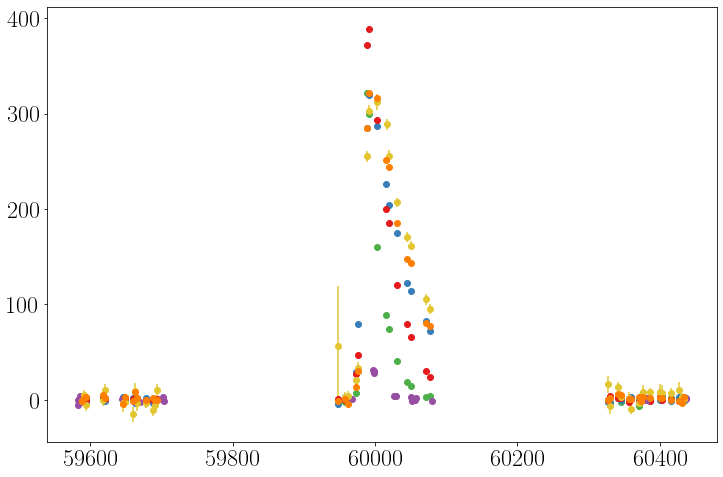

In [10]:
object_id = 33191 # 33191 is a nice looking object
f, ax = plot_event(object_id, df, list(np.unique(df['filter'])), LSST_PB_COLORS)

In [11]:
object_list = list(np.unique(df['object_id']))
obs_transient, _ = __transient_trim(object_list[190:200], df)

/Users/tallamjr/github/tallamjr/origin/astronet/astronet/preprocess.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_transient["mjd"]
/Users/tallamjr/github/tallamjr/origin/astronet/astronet/preprocess.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_transient["mjd"]
/Users/tallamjr/github/tallamjr/origin/astronet/astronet/preprocess.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

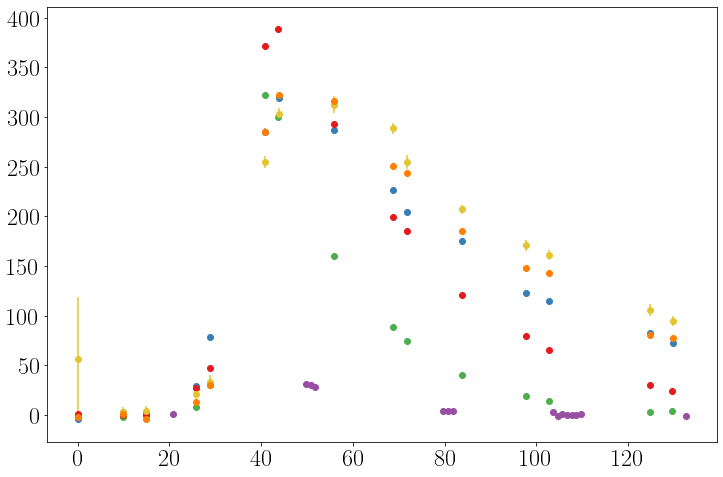

In [12]:
f, ax = plot_event(object_id, obs_transient, list(np.unique(df['filter'])), LSST_PB_COLORS)

In [13]:
obs_transient_single = obs_transient[obs_transient['object_id'] == 33191]
obs_transient_single.head()

,object_id,mjd,filter,flux,flux_error,detected
222,33191,0,lsstr,1.18219,1.38192,0
223,33191,0.0076,lsstg,-1.60304,1.32138,0
224,33191,0.0152,lssti,-4.31442,2.08156,0
225,33191,0.0262,lsstz,-1.70627,3.97542,0
226,33191,0.0332,lssty,56.0353,62.8119,0


In [14]:
from astronet.preprocess import generate_gp_single_event

In [15]:
obj_gps = generate_gp_single_event(df=obs_transient_single)

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:xlabel='Time (days)', ylabel='Flux units'>)

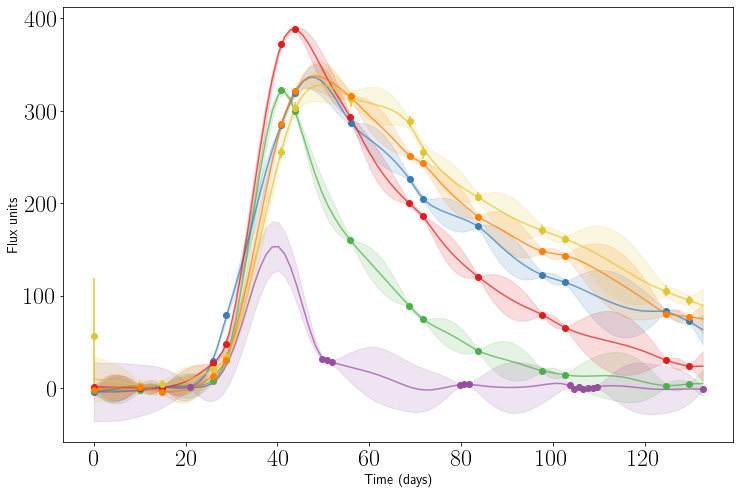

In [16]:
plot_event_data_with_model(obs_transient_single, obj_model=obj_gps, pb_colors=LSST_PB_COLORS, show_legend=False)

In [17]:
df = pd.read_parquet(f"{ROOT}/data/plasticc/transformed_df.parquet", engine="pyarrow")
df.head()

,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,target
0,0.000000,2.188022,32.456174,20.774066,-1.460222,43.731538,40.918486,730,42
1,1.210748,2.111767,32.148651,20.629250,-1.450371,43.379541,40.576529,730,42
2,2.421497,2.040803,31.830852,20.477900,-1.437434,43.014229,40.222258,730,42
3,3.632245,1.973938,31.501954,20.320099,-1.421548,42.635652,39.855700,730,42
4,4.842994,1.910180,31.160808,20.156196,-1.402868,42.243960,39.476972,730,42


##### Test tranformation of `training_set.csv`

In [18]:
# data = pd.read_csv("astronet/data/plasticc/training_set.csv", sep=',')
# df = remap_filters(data, LSST_FILTER_MAP)
# df.rename({'flux_err': 'flux_error'}, axis='columns', inplace=True)

In [19]:
# from astronet.constants import LSST_PB_WAVELENGTHS
# from astronet.utils import generate_gp_all_objects

# if not isinstance(object_id, list):
#     object_list = [object_id]
# df_gp_mean = generate_gp_all_objects(
#     object_list, df, pb_wavelengths=LSST_PB_WAVELENGTHS
# )

In [20]:
# df_gp_mean.head()

In [21]:
# from astronet.utils import __load_plasticc_dataset_from_csv
# df = __load_plasticc_dataset_from_csv(timesteps=100)
# df.head()

In [22]:
# df.equals(df_gp_mean)

33191 42


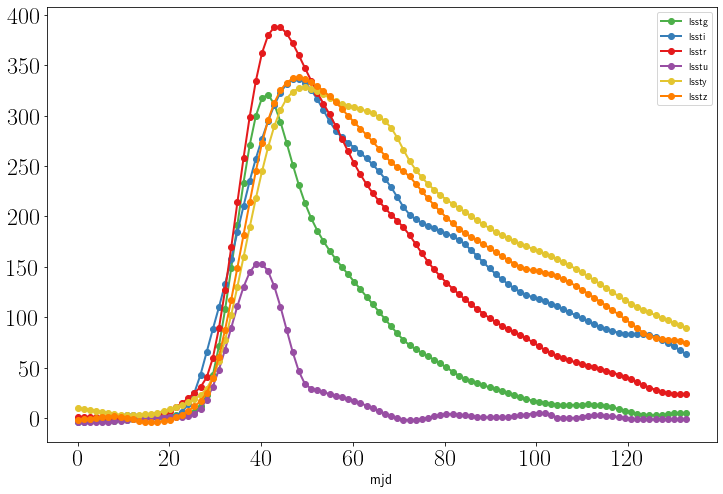

In [23]:
from astronet.viz.visualise_data import plot_event_gp_mean
f, ax = plot_event_gp_mean(df, 33191, pb_colors=LSST_PB_COLORS)